In [5]:
import numpy as np
import pandas as pd
import scipy.stats as stat
from scipy.optimize import newton_krylov
from scipy.integrate import dblquad
from itertools import combinations, chain, repeat
from tqdm import trange
from time import sleep

In [6]:
def linear_additive(x):
    term1 = 2*x[0]
    term2 = 3*x[1]
    return term1 + term2

In [7]:
def ishigami(x, a=7, b=0.1):
    '''Ishigami test function'''
    # check whether the input x is a dataframe
    
    if not isinstance(x, (pd.core.frame.DataFrame, pd.core.series.Series, np.ndarray, list)):
        raise TypeError('`x` must be of type pandas.DataFrame, numpy.ndarray, pd.Series, or list')
    
    if x.shape[0] > 3:
        raise ValueError('`x` must have only three arguments at a time')
    
    return np.sin(x[0]) + a*(np.sin(x[1])**2) + b*(x[2]**4)*np.sin(x[0])

In [8]:
def factor_ranking(factors):
    # gather indices for sorting factor
    temp = np.argsort(factors)[::-1]
    # create an array the same shape and type as temp
    ranks = np.empty_like(temp)
    # rank factors
    ranks[temp] = np.arange(len(factors))

    return ranks
    

In [9]:
# helper functions
def apply_unique(func, df, axis=1, *args, **kwargs):
    '''Apply a function to unique rows of a DataFrame
    for efficiency.'''

    applied_df = df.merge(df.drop_duplicates()
                         .assign(**{func.__name__: lambda x: x.apply(func, axis=axis)}), 
                         how='left')
    applied_df.index = df.index
    
    return applied_df
    
    
def scale(df, bounds, axis=1, *args, **kwargs):
    '''scale the sampled matrix
    bounds is a dict with ['ub', 'lb'] keys
    the values are lists of the upper and lower bounds
    of the parameters/variables/factors'''
    
    # numpy equivalent for math operations
    bounds_np = {key:np.array(value) for key,value in bounds.items()}
    display(bounds_np)
    
    if axis:
        return df * (bounds_np['ub'] - bounds_np['lb']) + bounds_np['lb']
    else:
        return df.T * (bounds_np['ub'] - bounds_np['lb']) + bounds_np['lb']
    
    
def pairs_h(iterable):
    '''gives the pairs of numbers considering their differences'''
    interval = range(min(iterable), max(iterable)-min(iterable))
    pairs  = {key+1:[j for j in combinations(iterable, 2) if np.abs(j[0]-j[1])==key+1] for key in interval}
    return pairs
    
    
def section_df(df, delta_h): # ***delta_h here is newly added*** July 6th, 2021 - Saman's comment
    '''gets the paired values of each section based on index'''
    pairs = pairs_h(df.index.get_level_values(-1))
    df_values = df.to_numpy()
    sample = pd.concat({h*delta_h:
                    pd.DataFrame.from_dict({str(idx_tup): [df_values[idx_tup[0]], df_values[idx_tup[1]]] for idx_tup in idx}, 'index') \
                      for h, idx in pairs.items()}) 

    return sample
    
    
# lambda functions
'''covariogram of each section'''
cov_section = lambda pair_cols, mu_star: (pair_cols.sub(mu_star, axis=0)[0] * pair_cols.sub(mu_star, axis=0)[1]).groupby(level=[0,1,2]).mean()

'''variogram over all sections'''
variogram = lambda pair_cols: 0.5*(pair_cols[0] - pair_cols[1]).pow(2).groupby(level=[1,2]).mean()

'''morris sensitivity measure equivalent evaluated over all sections'''
morris_eq = lambda pair_cols: ((pair_cols[1] - pair_cols[0]).abs().groupby(level=[1,2]).mean(), \
                               (pair_cols[1] - pair_cols[0]).groupby(level=[1,2]).mean())

'''covariogram over all sections'''
covariogram = lambda pair_cols, mu_overall: ((pair_cols - mu_overall)[0] * (pair_cols - mu_overall)[1]).groupby(level=[1,2]).mean()

'''expected covariogram over all sections'''
e_covariogram = lambda cov_section_all: cov_section_all.groupby(level=[1,2]).mean()

'''sobol (total order) sensitivity measure equivalent evaluated over all sections''' # new sobol added *** 6 July 2021
# sobol_eq = lambda gamma, ecov, variance: ((gamma + ecov) / variance).loc[:,1]
sobol_eq = lambda gamma, ecov, variance, delta_h: ((gamma + ecov) / variance)[:, delta_h] # new July 6, 2021



# ivars function
def ivars(variogram_array, scale, delta_h):
    '''generate Integrated Variogram Across a Range of Scales (IVARS)
    by approximating area using right trapezoids having width of `delta_h`
    and hights of variogram values'''
    num_h  = len(variogram_value.index.levels[-1].to_list())
    x_bench= np.arange(start=0, stop=delta_h*(num_h+1), step=delta_h)
    x_int  = np.arange(start=0, stop=(scale*10+1)/10, step=delta_h)

    # calculate interpolated values for both x (h) and y (variogram)
    if x_int[-1] < scale:
        x_int.append(scale)
    y_bench= [0] + variogram_array.to_list()

    y_int  = np.interp(x=x_int, xp=x_bench, fp=y_bench)
    
    # for loop for each step size to caluclate the area
    ivars = 0
    for i in range(len(x_int)-1):
        ivars += 0.5*(y_int[i+1] + y_int[i]) * (x_int[i+1] - x_int[i])

    return ivars

# alias
ind = pd.IndexSlice

In [10]:
from tqdm.autonotebook import tqdm

def apply_unique(func, df, axis=1, *args, **kwargs):
    '''Apply a function to unique rows of a DataFrame
    for efficiency.'''
    
    tqdm.pandas(desc=func.__name__ + ' evaluation')

    applied_df = df.merge(df.drop_duplicates()
                         .assign(**{func.__name__: lambda x: x.progress_apply(func, axis=axis)}), 
                         how='left')
    applied_df.index = df.index
    
    return applied_df

<ipython-input-10-2b471e26cf18>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [150]:
def reorder_pairs(pair_df, num_stars, parameters, df, delta_h):
    # gather the actual 'h' differences between each star point value for every pair
    # possibly find a faster way to do this later
    dist_list = []
    for star_centre in tqdm(range(0, num_stars), desc = 'calculating \'h\' values'):
        param_num=0
        for param in parameters.keys():
            pairs = pairs_h(df.loc[star_centre, param][param_num].index.get_level_values(-1))
            for ignore, idx in pairs.items():
                for idx_tup in idx:
                    dist_list.append(np.abs(df.loc[star_centre, param][param_num][idx_tup[0]] - df.loc[star_centre, param][param_num][idx_tup[1]]))
                                                                
    
            param_num = param_num + 1
    
    # loading bar for binning and reording pairs based on new 'h' values
    pairs_pbar = tqdm( desc='binning and reording pairs based on \'h\' values', total=2, dynamic_ncols=True)
    
    # this is to check that the above block is computing the differences in the right pair order
    pairs_h(df.loc[0, 'x1'][0].index.get_level_values(-1))
    
    # drop old distance values
    pair_df = pair_df.droplevel('h')
    
    # add new distances to dataframe
    pair_df['h'] = dist_list
    
    # create bin ranges
    num_bins = int(1/delta_h) # the number of bins created by delta h
    #bins = np.arange(start=delta_h/2, step=delta_h, stop=1) # create middle bin ranges
    bins = np.linspace(start=0, stop=3.14-(-3.14), num=num_bins+1)
    display(bins) # delete this
    
    # create labels for the bin ranges which will be the actual delta h values
    labels = np.arange(start=delta_h, step=delta_h, stop=1+delta_h)

    # bin pair values according to their distances 'h' for each paramter at each star centre
    binned_pairs = []
    for star_centre in range(0, num_stars):
        for param in parameters.keys():
            binned_pairs.append(pd.cut(pair_df.loc[star_centre, param, :]['h'], bins=bins, labels=labels).sort_values())
    
    # put binned pairs into a panda series
    binned_pairs = pd.concat(binned_pairs, ignore_index=False)
    
    pairs_pbar.update(1)
    
    # re order pairs values according to the bins
    pair_df = pair_df.loc[binned_pairs.index]
    
    # add in new index h, according to bin ranges
    # ex.) h = 0.1 = [0-0.15], h = 0.2 = [0.15-0.25]
    h = list(binned_pairs.values)
    
    # drop actual h values for new rounded ones
    pair_df.drop(columns='h')
    
    pair_df['h'] = h
    
    # format data frame so that it works properly with variogram analsysis functions
    pair_df.set_index('h', append=True, inplace=True)
    
    pair_df = pair_df.reorder_levels(['centre', 'param', 'h', 'pair_ind'])
    
    sleep(0.1)
    pairs_pbar.update(1)
    pairs_pbar.close()
    
    return pair_df
    

In [12]:
def rx2rn(distpair_type, param1, param2, rxpair):
    
    # getting the inverse cdf of distribution 1
    if (distpair_type[0] == 'unif'):
        mu1 = (param1[1] + param1[0])/2
        std1 = (param1[1] - param1[0])/12**0.5
        inv_cdf1 = lambda x : param1[0] + (param1[1] - param1[0])*x
    elif (distpair_type[0] == 'norm'):
        mu1 = param1[0]
        std1 = param1[1]
        inv_cdf1 = lambda x : stat.norm.ppf(x, mu1, std1)
    elif (distpair_type[0] == 'triangle'):
        mu1 = (param1[0] + param1[1] + param1[2])/3
        std1 = (np.sqrt(param1[0]**2+param1[1]**2+param1[2]**2-param1[0]*param1[1]-param1[0]*param1[2]-param1[1]*param1[2]))/np.sqrt(18)
        mid1=(param1[2]-param1[0])/(param1[1]-param1[0])
        term11= (param1[1]-param1[0])*(param1[2]-param1[0])
        term21= (param1[1]-param1[0])*(param1[1]-param1[2])
        inv_cdf1 = lambda x : ((param1[0]+np.sqrt(term11)*np.sqrt(x/1))*((x>=0).astype(int))*((x<mid1).astype(int)) + (param1[1]-np.sqrt(term21)*np.sqrt(1-x))*((x>=mid1).astype(int))*((x<1).astype(int)))
    elif (distpair_type[0] == 'lognorm'):
        mu1= param1[0]
        std1=param1[1]
        # compute associated normal
        cv=std1/mu1**2
        m = np.log(mu1/(np.sqrt(1+cv)))
        v = np.sqrt(np.log(1+cv))           
        inv_cdf1 = lambda x : stat.lognorm.ppf(x, scale=np.exp(m), s=v, loc=0)
    elif (distpair_type[0] == 'expo'):
        lamda= param1[0]
        mu1=1/lamda
        std1=1/(lamda**2)
        inv_cdf1 = lambda x : stat.expon.ppf(x, scale=mu1)
    elif (distpair_type[0] == 'gev'):
        mu=param1[0] #location
        sigma=param1[1] #scale
        k1=param1[2] #shape
        inv_cdf1 = lambda x : stat.genextreme.ppf(x,c=k1,scale=sigma,loc=mu);
        [mu1,std1] = stat.genextreme.stats(k1,scale=sigma,loc=mu);
        
    # getting the inverse cdf of distribution 2
    if (distpair_type[1] == 'unif'):
        mu2 = (param2[1] + param2[0])/2
        std2 = (param2[1] - param2[0])/12**0.5
        inv_cdf2 = lambda x : param2[0] + (param2[1] - param2[0])*x
    elif (distpair_type[1] == 'norm'):
        mu2 = param2[0]
        std2 = param2[1]
        inv_cdf2 = lambda x : stat.norm.ppf(x, mu2, std2)
    elif (distpair_type[1] == 'triangle'):
        mu2 = (param2[0] + param2[1] + param2[2])/3
        std2 = (np.sqrt(param2[0]**2+param2[1]**2+param2[2]**2-param2[0]*param2[1]-param2[0]*param2[2]-param2[1]*param2[2]))/np.sqrt(18)
        mid2=(param2[2]-param2[0])/(param2[1]-param2[0])
        term12= (param2[1]-param2[0])*(param2[2]-param2[0])
        term22= (param2[1]-param2[0])*(param2[1]-param2[2])
        inv_cdf2 = lambda x : ((param2[0]+np.sqrt(term12)*np.sqrt(x/1))*((x>=0).astype(int))*((x<mid2).astype(int)) + (param2[1]-np.sqrt(term22)*np.sqrt(1-x))*((x>=mid1).astype(int))*((x<1).astype(int)))
    elif (distpair_type[1] == 'lognorm'):
        mu2= param2[0]
        std2=param2[1]
        # compute associated normal
        cv=std2/mu2**2
        m = np.log(mu2/(np.sqrt(1+cv)))
        v = np.sqrt(np.log(1+cv))           
        inv_cdf2 = lambda x : stat.lognorm.ppf(x, scale=np.exp(m), s=v, loc=0)
    elif (distpair_type[1] == 'expo'):
        lamda= param2[0]
        mu2=1/lamda
        std2=1/(lamda**2)
        inv_cdf2 = lambda x : stat.expon.ppf(x, scale=mu2)
    elif (distpair_type[1] == 'gev'):
        mu=param2[0] #location
        sigma=param2[1] #scale
        k2=param2[2] #shape
        inv_cdf2 = lambda x : stat.genextreme.ppf(x,c=k2,scale=sigma,loc=mu)
        [mu2,std2] = stat.genextreme.stats(k2,scale=sigma,loc=mu)
    
    # bivariate standard normal distribution
    stdnorm2_pdf = lambda x1, x2 : np.exp(-1*(x1**2 + x2**2)/2.0)/(2.0*np.pi)
    
    # integral bound zmax=5.0, zmin = -5.0
    integrand = lambda x1, x2 : inv_cdf1(stat.norm.cdf(x1*np.sqrt(1-rxpair**2)+ rxpair*x2,0,1))*inv_cdf2(stat.norm.cdf(x2,0,1))*stdnorm2_pdf(x1, x2)
    # compute double integral of integrand with x1 ranging from -5.0 to 5.0 and x2 ranging from -5.0 to 5.0
    rn = (dblquad(integrand, -5.0, 5.0, lambda x : -5.0, lambda x : 5.0) - mu1*mu2)/(std1*std2)
    
    return rn

In [13]:
def rn2rx(distpair_type, param1, param2, rnpair):    
    fun = lambda r : (rnpair - rx2rn(distpair_type, param1, param2, r))
    # try to find point x where fun(x) = 0
    try:
        rx = newton_krylov(fun, rnpair, x_tol=1e-5)
    except:
        rx = rnpair
            
    return rx    

In [14]:
def map_2_cornorm(parameters, corr_mat):
    # store parameter info in a list
    param_info = list(parameters.values())
    
    corr_n = np.eye(corr_mat.shape[0], corr_mat.shape[1])
    for i in range(0, corr_mat.shape[0] - 1):
        for j in range(i+1, corr_mat.shape[0]):
            # input paramter info (lb, ub, ?, dist type)
            corr_n[i][j] = rn2rx([param_info[i][3], param_info[j][3]], [param_info[i][0], param_info[i][1], param_info[i][2]],[param_info[j][0], param_info[j][1], param_info[j][2]],corr_mat[i][j])
            # matrix is symmetrical
            corr_n[j][i] = corr_n[i][j]
    return corr_n

In [15]:
def n2x_transform(norm_vectors, parameters):
    # Transform from correlated standard normal to original distributions
    param_info = list(parameters.values())
    
    # 
    k = norm_vectors.shape[1]   
    x = np.zeros(norm_vectors.shape)

    for i in range(0, k):
        if param_info[i][3] == 'unif':
            lb = param_info[i][0]
            ub = param_info[i][1]

            x[:, i] = lb + (ub - lb)*stat.norm.cdf(norm_vectors[:, i],0,1)
        elif param_info[i][3] == 'norm':
            mu = param_info[i][0]
            std = param_info[i][1]

            x[:, i] = stat.norm.ppf(stat.norm.cdf(norm_vectors[:, i],0,1), mu, std)
        elif param_info[i][3] == 'triangle':
            a = param_info[i][0]
            b = param_info[i][1]
            c = param_info[i][2]
            mid = (c-a)/(b-a)
            term1 = (b-a)*(c-a)
            term2 = (b-a)*(b-c)
            x_norm = stat.norm.cdf(norm_vector[:, i],0,1)
            x[:, i] = (a+np.sqrt(term1)*np.sqrt(x_norm))*((x_norm >= 0).astype(int))*((x_norm < mid).astype(int))+(b-np.sqrt(term2)*np.sqrt((1-x_norm)))*((x_norm >= mid).astype(int))*((x_norm < 1).astype(int))
        elif param_info[i][3] == 'lognorm':
            mu = param_info[i][0]
            std = param_info[i][1]
            term1 = std/mu**2
            m = np.log(mu/(np.sqrt(1+term1)))
            v = np.sqrt(np.log(1+term1))
            x[:, i] = np.lognorm.ppf(stat.norm.cdf(norm_vectors[:, i],0,1), scale=np.exp(mu), s=std, loc=0)
        elif param_info[i][3] == 'expo':
            mu = param_info[i][0]
            x[:, i] = np.expon.ppf(stat.norm.cdf(norm_vectors[:, i],0,1), scale=mu)
        elif param_info[i][3] == 'gev':
            mu = param_info[i][0] # location
            sigma = param_info[i][1] # scale
            k = param_info[i][2] # shape
            x[:, i] = stat.genextreme.ppf(stat.norm.cdf(norm_vectors[:, i],0,1),c=k,scale=sigma,loc=mu)
        
    return x

In [16]:
# GVARS inputs
num_stars = 250
num_dir_samples = 25
delta_h = 0.05
ivars_scales = [0.1, 0.3, 0.5]
parameters = {'x1' : (-3.14, 3.14, None, 'unif'),
              'x2' : (-3.14, 3.14, None, 'unif'),
              'x3' : (-3.14, 3.14, None, 'unif')}
corr_mat = np.array([[1, 0, 0.8], [0, 1, 0], [0.8, 0, 1]])
n_var = len(parameters)
n_var

3

In [17]:
stars_pbar = tqdm(desc='generating star points', total=10, dynamic_ncols=True)
cov_mat = map_2_cornorm(parameters, corr_mat)
stars_pbar.update(1)
cov_mat

generating star points:   0%|          | 0/10 [00:00<?, ?it/s]

array([[1. , 0. , 0.8],
       [0. , 1. , 0. ],
       [0.8, 0. , 1. ]])

In [124]:
# Generate independent standard normal samples
# the amount of samples is the same as the amount of stars
#U = np.random.default_rng().multivariate_normal(np.zeros(n_var), np.eye(n_var), size=num_stars)
#stars_pbar.update(1)
df3 = pd.read_csv('Book1.csv', sep=',',header=None)
df3.values.shape
U = df3.values
U

array([[ 9.40510580e-01, -2.12968626e-01,  5.69715119e-01],
       [-1.79558197e-01, -5.95367137e-01, -9.66906629e-01],
       [ 5.12252290e-02,  1.02607134e+00, -7.08522963e-01],
       [ 1.80877352e+00,  1.11785812e-01, -8.74536680e-02],
       [ 1.38903710e+00, -3.33221923e-01, -1.71929460e-01],
       [ 3.15817968e-01, -3.24802903e-01,  8.34786302e-01],
       [ 1.88312531e-01, -3.48966943e-01, -2.94715478e-01],
       [ 1.55888290e+00,  1.00409039e+00, -1.06059515e+00],
       [ 6.59754314e-01, -1.77602225e+00,  3.44859560e-01],
       [ 4.48608980e-02, -4.78199955e-01,  2.60969198e-01],
       [ 1.85874723e-01, -1.94705517e+00,  2.48653241e+00],
       [ 5.42750963e-01,  9.66851873e-01,  1.39208148e+00],
       [-5.87326592e-01, -1.40472772e+00,  5.88584045e-01],
       [-4.21800929e-01, -8.28075770e-01,  1.07161606e+00],
       [-7.75985640e-01, -9.87854388e-01, -2.47085120e-01],
       [ 3.50558081e-01,  1.04847488e+00, -1.75279950e+00],
       [-1.80004046e-01, -6.43830470e-02

In [125]:
# Generate correlated standard normal samples
# the amount of samples is the same as the amount of stars
cholU = np.linalg.cholesky(cov_mat)
cholU = cholU.transpose() # to get in correct format for matrix multiplication
Z = np.matmul(U,cholU) # transform samples to standard normal distribution
stars_pbar.update(1)
display(cholU)
display(Z)

array([[1. , 0. , 0.8],
       [0. , 1. , 0. ],
       [0. , 0. , 0.6]])

array([[ 9.40510580e-01, -2.12968626e-01,  1.09423754e+00],
       [-1.79558197e-01, -5.95367137e-01, -7.23790535e-01],
       [ 5.12252290e-02,  1.02607134e+00, -3.84133595e-01],
       [ 1.80877352e+00,  1.11785812e-01,  1.39454662e+00],
       [ 1.38903710e+00, -3.33221923e-01,  1.00807201e+00],
       [ 3.15817968e-01, -3.24802903e-01,  7.53526156e-01],
       [ 1.88312531e-01, -3.48966943e-01, -2.61792620e-02],
       [ 1.55888290e+00,  1.00409039e+00,  6.10749227e-01],
       [ 6.59754314e-01, -1.77602225e+00,  7.34719187e-01],
       [ 4.48608980e-02, -4.78199955e-01,  1.92470237e-01],
       [ 1.85874723e-01, -1.94705517e+00,  1.64061922e+00],
       [ 5.42750963e-01,  9.66851873e-01,  1.26944966e+00],
       [-5.87326592e-01, -1.40472772e+00, -1.16710847e-01],
       [-4.21800929e-01, -8.28075770e-01,  3.05528894e-01],
       [-7.75985640e-01, -9.87854388e-01, -7.69039584e-01],
       [ 3.50558081e-01,  1.04847488e+00, -7.71233233e-01],
       [-1.80004046e-01, -6.43830470e-02

In [126]:
# Generate Nstar actual multivariate samples X
X = n2x_transform(Z, parameters)
stars_pbar.update(1)
X

array([[ 2.05055902, -0.5295565 ,  2.28010845],
       [-0.44745181, -1.40798201, -1.66672977],
       [ 0.12828141,  2.18274601, -0.93923858],
       [ 2.91867335,  0.27948123,  2.62770083],
       [ 2.62246059, -0.81964434,  2.15586153],
       [ 0.77827827, -0.79966302,  1.72343987],
       [ 0.46901658, -0.85686164, -0.06558092],
       [ 2.76626433,  2.14984796,  1.44011198],
       [ 1.54044787, -2.90221015,  1.68771693],
       [ 0.1123549 , -1.15392521,  0.47924602],
       [ 0.46301496, -2.9782017 ,  2.82324785],
       [ 1.29587398,  2.0924392 ,  2.49855849],
       [-1.39106903, -2.63727891, -0.29173993],
       [-1.02624517, -1.86004937,  0.75371503],
       [-1.76544156, -2.12507674, -1.75252879],
       [ 0.86061148,  2.21552161, -1.75661429],
       [-0.44855091, -0.16119118,  1.26220702],
       [ 1.14852508, -0.58909762,  1.10747574],
       [-2.43565857, -1.39851987, -0.03492154],
       [-1.67929753,  1.87934362,  0.04963507],
       [ 2.09493204, -2.63405568,  2.514

In [127]:
# define index matrix of complement subset
compsub = np.empty([n_var, n_var-1])
for i in range (0, n_var):

    temp = np.arange(n_var)
    compsub[i] = np.delete(temp, i)   
compsub = compsub.astype(int)
stars_pbar.update(1)
compsub

array([[1, 2],
       [0, 2],
       [0, 1]])

In [128]:
# computer coditional variance and conditional expectation for each star center
chol_cond_std = []
std_cond_norm = []
mui_on_noti = np.zeros((len(Z), n_var))
for i in range(0, n_var):
    noti = compsub[i]
    # 2 dimensional or greater matrix case
    if (cov_mat[noti,:][:,noti].ndim >= 2):
        cond_std = cov_mat[i][i] - np.matmul(cov_mat[i,noti], np.matmul(np.linalg.inv(cov_mat[noti,:][:,noti]),cov_mat[noti,i]))
        chol_cond_std.append(np.linalg.cholesky([[cond_std]]).flatten())
        std_cond_norm.append(cond_std)
        for j in range(0, len(Z)):
            mui_on_noti[j][i] = np.matmul(cov_mat[i,noti], np.matmul(np.linalg.inv(cov_mat[noti,:][:,noti]),Z[j,noti]))
    # less then 2 dimenional matrix case
    else:
        cond_std = cov_mat[i][i] - np.matmul(cov_mat[i,noti],np.matmul(cov_mat[noti,:][:,noti],cov_mat[noti,i]))
        chol_cond_std.append(np.linalg.cholesky([[cond_std]]).flatten())
        std_cond_norm.append(cond_std)
        for j in range(0, len(Z)):
            mui_on_noti[j][i] = np.matmul(cov_mat[i, noti],np.matmul(cov_mat[noti,:][:,noti]*Z[j, noti]))
stars_pbar.update(1)
display(std_cond_norm)
display(chol_cond_std)
display(mui_on_noti)

[0.3599999999999999, 1.0, 0.3599999999999999]

[array([0.6]), array([1.]), array([0.6])]

array([[ 8.75390028e-01,  0.00000000e+00,  7.52408464e-01],
       [-5.79032428e-01,  0.00000000e+00, -1.43646558e-01],
       [-3.07306876e-01,  0.00000000e+00,  4.09801832e-02],
       [ 1.11563729e+00,  0.00000000e+00,  1.44701882e+00],
       [ 8.06457604e-01,  0.00000000e+00,  1.11122968e+00],
       [ 6.02820924e-01,  0.00000000e+00,  2.52654374e-01],
       [-2.09434096e-02,  0.00000000e+00,  1.50650025e-01],
       [ 4.88599382e-01,  0.00000000e+00,  1.24710632e+00],
       [ 5.87775350e-01,  0.00000000e+00,  5.27803451e-01],
       [ 1.53976190e-01,  0.00000000e+00,  3.58887184e-02],
       [ 1.31249538e+00,  0.00000000e+00,  1.48699778e-01],
       [ 1.01555973e+00,  0.00000000e+00,  4.34200770e-01],
       [-9.33686773e-02,  0.00000000e+00, -4.69861274e-01],
       [ 2.44423115e-01,  0.00000000e+00, -3.37440743e-01],
       [-6.15231667e-01,  0.00000000e+00, -6.20788512e-01],
       [-6.16986587e-01,  0.00000000e+00,  2.80446465e-01],
       [ 4.21796254e-01,  0.00000000e+00

In [40]:
# Generate directional sample:
# Create samples in correlated standard normal space
all_section_condZ = []
condZ = []
for j in range(0, num_dir_samples):
    stnrm_base = np.random.default_rng().multivariate_normal(np.zeros(n_var), np.eye(n_var), size=num_stars)
    for i in range(0, n_var):
        condZ.append(stnrm_base[:, i]*chol_cond_std[i] + mui_on_noti[:, i])
    all_section_condZ.append(condZ.copy())
    condZ.clear()
stars_pbar.update(1)
    
np.array(all_section_condZ).shape

(25, 3, 250)

In [129]:
df3 = pd.read_csv('myDataFile.csv')

In [130]:
all_section_condZ = df3.values.reshape([25, 3, 250])

In [131]:
all_section_condZ[0][0]

array([ 0.75693592, -0.86842666, -0.18641869,  0.3417866 ,  0.67493917,
       -0.10258721, -0.34109921,  1.13824561,  0.72655063, -0.11367986,
        1.54720876,  1.18863048, -0.33735678, -0.51264683,  0.46148655,
       -0.58696626,  1.40982252,  0.3377483 ,  0.7305788 ,  0.37265561,
        1.02226346, -0.93200988,  0.91553536,  0.27831398,  0.71532185,
        0.85365681,  0.27330911,  0.88558549, -0.37247943, -0.11275899,
        1.70629826, -0.8957258 , -0.99289171, -0.53271247, -0.21464167,
       -0.37693572,  0.95363754, -0.49091724, -0.35552751,  0.12540396,
       -0.68640625,  0.23915046,  0.21099885,  1.83184228,  0.39669731,
        0.3276553 ,  1.69617331, -0.02243044, -0.06687318,  0.16060885,
        1.11274383, -1.05146597,  0.96721614, -2.3007478 , -0.28453003,
       -0.0826376 , -1.91783815, -0.98806948,  1.51548709,  0.73237361,
       -0.85459692, -1.09114106,  1.45912472,  0.33952896, -0.56838239,
       -1.16422938, -1.82717988,  0.1221515 ,  1.11380752, -0.56

In [132]:
# transform to original distribution and compute response surface
Xi_on_Xnoti = []
tmp1 = []
Xi_on_Xnoti_and_Xnoti_temp = []
Xi_on_Xnoti_and_Xnoti = []
for j in range(0, num_dir_samples):
    for i in range(0, len(parameters)):
        tmp1.append(n2x_transform(np.array([all_section_condZ[j][i]]).transpose(), parameters).flatten())
        tmp2 = X.copy()
        tmp2[:, i] = tmp1[i]
        Xi_on_Xnoti_and_Xnoti_temp.append(tmp2.copy()) 
    # attatch results from tmp1 onto Xi_on_Xnoti and Xi_on_Xnoti_and_Xnoti
    Xi_on_Xnoti.append(tmp1.copy())
    tmp1.clear() # clear for next iteration
    Xi_on_Xnoti_and_Xnoti.append(Xi_on_Xnoti_and_Xnoti_temp.copy())
    Xi_on_Xnoti_and_Xnoti_temp.clear() # clear for next iteration
stars_pbar.update(1)
np.array(Xi_on_Xnoti_and_Xnoti).shape # check that shape is the same as all_section condZ

(25, 3, 250, 3)

In [133]:
# Put Star points into a dataframe
params = [*parameters]
star_points = {}
points = {}
temp = np.zeros([num_dir_samples, len(parameters)])
for i in range(0, num_stars):
    for j in range(0, len(parameters)):
        for k in range(0, num_dir_samples):
            temp[k, :] = Xi_on_Xnoti_and_Xnoti[k][j][i]
        points[params[j]] = np.copy(temp)
    star_points[i] = points.copy()
stars_pbar.update(1)

True

In [134]:
star_points_df = pd.concat({key: pd.concat({k: pd.DataFrame(d) for k, d in value.items()}) for key, value in star_points.items()})
star_points_df.index.names=['centre', 'param', 'points']
stars_pbar.update(1)
star_points_df

0         1         2
centre param points                              
0      x1    0       1.729863 -0.529556  2.280108
             1       1.799905 -0.529556  2.280108
             2       1.033873 -0.529556  2.280108
             3       0.640796 -0.529556  2.280108
             4       1.373718 -0.529556  2.280108
...                       ...       ...       ...
249    x3    20      1.782136  1.505817 -0.052914
             21      1.782136  1.505817  1.631011
             22      1.782136  1.505817  0.567268
             23      1.782136  1.505817  1.116966
             24      1.782136  1.505817 -0.260018

[18750 rows x 3 columns]

In [135]:
model_name = ishigami
df = apply_unique(model_name, star_points_df, axis=1)
df.index.names=['centre', 'param', 'points']
df

ishigami evaluation:   0%|          | 0/18750 [00:00<?, ?it/s]

0         1         2  ishigami
centre param points                                        
0      x1    0       1.729863 -0.529556  2.280108  5.442344
             1       1.799905 -0.529556  2.280108  5.392332
             2       1.033873 -0.529556  2.280108  4.968050
             3       0.640796 -0.529556  2.280108  3.999928
             4       1.373718 -0.529556  2.280108  5.417414
...                       ...       ...       ...       ...
249    x3    20      1.782136  1.505817 -0.052914  7.948237
             21      1.782136  1.505817  1.631011  8.640155
             22      1.782136  1.505817  0.567268  7.958361
             23      1.782136  1.505817  1.116966  8.100427
             24      1.782136  1.505817 -0.260018  7.948683

[18750 rows x 4 columns]

In [152]:
# getting the paired values of each section based on `h`
tqdm.pandas(desc='building pairs')

pair_df = df[model_name.__name__].groupby(level=[0,1]).progress_apply(section_df, delta_h=delta_h)
pair_df.index.names = ['centre', 'param', 'h', 'pair_ind']
pair_df

building pairs:   0%|          | 0/750 [00:00<?, ?it/s]

0         1
centre param h    pair_ind                    
0      x1    0.05 (0, 1)    5.442344  5.392332
                  (1, 2)    5.392332  4.968050
                  (2, 3)    4.968050  3.999928
                  (3, 4)    3.999928  5.417414
                  (4, 5)    5.417414  4.419324
...                              ...       ...
249    x3    1.10 (1, 23)   8.154320  8.100427
                  (2, 24)   9.702787  7.948683
             1.15 (0, 23)   7.954826  8.100427
                  (1, 24)   8.154320  7.948683
             1.20 (0, 24)   7.954826  7.948683

[225000 rows x 2 columns]

In [153]:
# bin and reorder pairs based on 'h'
pair_df = reorder_pairs(pair_df, num_stars, parameters, df, delta_h)
pair_df

calculating 'h' values:   0%|          | 0/250 [00:00<?, ?it/s]

binning and reording pairs based on 'h' values:   0%|          | 0/2 [00:00<?, ?it/s]

array([0.   , 0.314, 0.628, 0.942, 1.256, 1.57 , 1.884, 2.198, 2.512,
       2.826, 3.14 , 3.454, 3.768, 4.082, 4.396, 4.71 , 5.024, 5.338,
       5.652, 5.966, 6.28 ])

0          1
centre param h    pair_ind                      
0      x1    0.05 (0, 1)     5.442344   5.392332
                  (12, 22)   2.214209   3.275067
                  (2, 5)     4.968050   4.419324
                  (3, 5)     3.999928   4.419324
                  (2, 18)    4.968050   5.058698
...                               ...        ...
249    x3    0.60 (11, 15)   8.201618  10.723542
             0.65 (5, 11)   12.401843   8.201618
                  (11, 16)   8.201618  13.026967
                  (11, 13)   8.201618  13.663337
             0.70 (4, 11)   14.297225   8.201618

[225000 rows x 2 columns]

In [154]:
vars_pbar = tqdm( desc='VARS Analysis', total=10, )

VARS Analysis:   0%|          | 0/10 [00:00<?, ?it/s]

In [155]:
# mu_star calculation

vars_pbar.update(1)
vars_pbar.write('Averages of model runs (`mu_star`) calculated - access via .mu_star_df')


mu_star_df = df[model_name.__name__].groupby(level=[0,1]).mean()
mu_star_df.index.names = ['centre', 'param']
mu_star_df.unstack(level=1)

Averages of model runs (`mu_star`) calculated - access via .mu_star_df


param,x1,x2,x3
centre,,,
0,3.585011,6.847100,4.817475
1,5.843665,2.844308,5.738171
2,4.299515,3.583107,4.840056
3,3.440944,5.007787,1.766480
4,5.590930,5.823781,5.570017
...,...,...,...
245,4.837895,1.533390,2.612098
246,3.159970,3.457945,4.105798
247,4.172595,4.890206,5.932439


In [156]:
# overall mu (mean) of the unique evaluated function values over all stars points

vars_pbar.update(1)
vars_pbar.write('Overall expected value (`mu_overall`) calculated - access via .mu_overall')

mu_overall = df[model_name.__name__].unique().mean()
mu_overall

Overall expected value (`mu_overall`) calculated - access via .mu_overall


3.755470167274803

In [157]:
# overall var (variance) of the unique evaluated function values over all stars points

vars_pbar.update(1)
vars_pbar.write('Overall variance (`var_overall`) calculated - access via .var_overall')


var_overall = df[model_name.__name__].unique().var(ddof=1)
var_overall

Overall variance (`var_overall`) calculated - access via .var_overall


12.000894220933297

In [158]:
# sectional covariogram calculation - content matches MATLAB code style!!

vars_pbar.update(1)
vars_pbar.write('Sectional covariogram `cov_section_all` calculated - access via .cov_section_all')


cov_section_all = cov_section(pair_df, mu_star_df)
cov_section_all.unstack(level=1)

Sectional covariogram `cov_section_all` calculated - access via .cov_section_all


param              x1        x2        x3
centre h                                 
0      0.05  2.150245  5.535706  5.253081
       0.10  2.070088  0.901348  2.466185
       0.15  1.716211 -2.394824  0.057939
       0.20  0.366882 -3.785384 -1.129280
       0.25 -0.035992 -5.772587 -1.206677
...               ...       ...       ...
249    0.70       NaN -3.590074 -5.613631
       0.75       NaN -6.487073       NaN
       0.80       NaN -1.622056       NaN
       0.85       NaN -0.779785       NaN
       0.90       NaN  1.486656       NaN

[4703 rows x 3 columns]

In [160]:
# variogram calculation

vars_pbar.update(1)
vars_pbar.write('Variogram (`gamma`) calculated - access via .gamma')

variogram_value = variogram(pair_df)
# replace missing values with 0
variogram_value = variogram_value.unstack(0).fillna(0).unstack(0)
variogram_value.unstack(level=0)

Variogram (`gamma`) calculated - access via .gamma


param,x1,x2,x3
h,,,
0.05,0.279323,0.408398,0.125506
0.10,1.345673,2.757792,0.746094
0.15,2.309837,6.673414,1.644454
0.20,2.547901,10.133460,2.371304
0.25,2.615683,11.940954,2.955134
0.30,2.230287,10.934243,3.346057
0.35,2.123537,8.481756,3.747234
0.40,2.688232,5.276465,3.928858
0.45,2.963504,2.334833,3.983541


In [162]:
# morris calculation

vars_pbar.update(1)
vars_pbar.write('Morris MAEE and MEE (`maee` and `mee`) calculated - access via .maee and .mee')


morris_values = morris_eq(pair_df)
morris_values[0].unstack(level=0)

Morris MAEE and MEE (`maee` and `mee`) calculated - access via .maee and .mee


param,x1,x2,x3
h,,,
0.05,0.463684,0.717672,0.303956
0.10,1.099570,2.123312,0.832604
0.15,1.427440,3.328840,1.247195
0.20,1.515180,4.086231,1.487222
0.25,1.583677,4.392822,1.662786
0.30,1.561524,4.171769,1.775967
0.35,1.599548,3.656985,1.921678
0.40,1.818118,2.844000,1.990004
0.45,1.924080,1.869182,2.007767


In [163]:
morris_values[1].unstack(level=0)

param,x1,x2,x3
h,,,
0.05,-0.003036,0.000330,-0.000857
0.10,0.005482,-0.042460,-0.003532
0.15,0.029596,-0.061935,-0.002833
0.20,0.032108,-0.213837,0.028673
0.25,-0.027272,-0.061815,0.001307
0.30,0.014616,-0.165620,-0.002607
0.35,-0.009856,-0.056020,-0.013740
0.40,-0.082144,-0.001181,0.070870
0.45,-0.117016,0.021132,-0.037636


In [164]:
# overall covariogram calculation

vars_pbar.update(1)
vars_pbar.write('Covariogram (`cov`) calculated - access via .cov')

covariogram_value = covariogram(pair_df, mu_overall)
covariogram_value.unstack(level=0)

Covariogram (`cov`) calculated - access via .cov


param,x1,x2,x3
h,,,
0.05,12.446272,11.103495,11.947196
0.10,12.064812,8.722811,11.382478
0.15,11.559705,5.177635,10.327269
0.20,10.283384,1.808501,9.791240
0.25,9.154588,-0.084000,9.593968
0.30,7.814539,0.443759,9.362637
0.35,6.619878,2.839670,9.152025
0.40,5.855650,6.837812,9.870543
0.45,4.772609,10.256168,9.415186


In [165]:
# expected value of the overall covariogram calculation

vars_pbar.update(1)
vars_pbar.write('Expected value of covariogram (`ecov`) calculated - access via .ecov')

e_covariogram_value = e_covariogram(cov_section_all)
e_covariogram_value.unstack(level=0)

Expected value of covariogram (`ecov`) calculated - access via .ecov


param,x1,x2,x3
h,,,
0.05,1.029085,4.708024,1.403528
0.10,0.356220,2.529889,0.847522
0.15,-0.211459,-0.766020,0.193793
0.20,-0.761269,-3.806684,-0.312931
0.25,-0.862776,-5.522986,-0.718765
0.30,-1.147631,-5.095943,-1.013018
0.35,-1.276880,-2.730535,-1.219645
0.40,-1.384249,0.514961,-1.424215
0.45,-1.146961,3.611753,-1.631471


In [166]:
# sobol calculation

vars_pbar.update(1)
vars_pbar.write('Sobol ST (`st`) calculated - access via .st')

sobol_value = sobol_eq(variogram_value, e_covariogram_value, var_overall, delta_h)
sobol_value

Sobol ST (`st`) calculated - access via .st


param
x1    0.109026
x2    0.426337
x3    0.127410
dtype: float64

In [167]:
# IVARS calculation

vars_pbar.update(1)
vars_pbar.write('IVARS (`ivars`) calculated - access via .ivars')

ivars_values = [0.1, 0.3, 0.5]
ivars_df = pd.DataFrame.from_dict({scale: variogram_value.groupby(level=0).apply(ivars, scale=scale, delta_h=delta_h) \
                      for scale in ivars_values}, 'index')
ivars_df

IVARS (`ivars`) calculated - access via .ivars


,x1,x2,x3
0.1,0.138996,0.325145,0.084691
0.3,0.619524,2.354457,0.653108
0.5,1.232673,2.977250,1.477012


In [38]:
vars_pbar.close()

In [39]:
# calculating rankings of sobol and ivars
sobol_ranking = factor_ranking(sobol_value)
sobol_ranking_df = pd.DataFrame(data=[sobol_ranking], columns=parameters.keys(), index=[''])
sobol_ranking_df

,x1,x2,x3
,2,0,1


In [40]:
ivars_ranking = []
for scale in ivars_scales:
    ivars_ranking.append(factor_ranking(ivars_df.loc[scale]))

ivars_ranking_df = pd.DataFrame(data=ivars_ranking, columns=parameters.keys(), index=ivars_scales)
ivars_ranking_df

,x1,x2,x3
0.1,1,0,2
0.3,1,0,2
0.5,1,0,2


In [41]:
# bootstrapping to get CIs
bootstrap_size = 100

# create result dataframes/series if bootstrapping is chosen to be done
result_bs_variogram = pd.DataFrame()
result_bs_sobol = pd.DataFrame()
result_bs_ivars_df = pd.DataFrame()
result_bs_sobol_ranking = pd.DataFrame()
result_bs_ivars_ranking = pd.DataFrame()

for _ in range(0, bootstrap_size):
    ## specify random sequence by sampling with replacement
    bootstrap_rand = np.random.choice(list(range(0,10)), size=len(range(0,10)), replace=True).tolist()
    bootstrapped_pairdf = pd.concat([pair_df.loc[ind[i, :, :, :], :] for i in bootstrap_rand])
    bootstrapped_df     = pd.concat([df.loc[ind[i, :, :], :] for i in bootstrap_rand])
    #display(bootstrapped_pairdf)
    #display(bootstrap_rand)

    ## calculating sectional covariograms
    bootstrapped_cov_section_all = pd.concat([cov_section_all.loc[ind[i, :]] for i in bootstrap_rand])
    #display('sectional variogram:')
    #display(bootstrapped_cov_section_all)
    #display(bootstrap_rand)

    ## calculating variogram, ecovariogram, variance, mean, Sobol, and IVARS values
    bootstrapped_variogram = variogram(bootstrapped_pairdf)
    # replace missing values with 0
    bootstrapped_variogram = bootstrapped_variogram.unstack(0).fillna(0).unstack(0)
    #display('variogram:')
    #display(bootstrapped_variogram)

    bootstrapped_ecovariogram = e_covariogram(bootstrapped_cov_section_all)
    #display('E(covariogram):')
    #display(bootstrapped_ecovariogram.unstack(level=0))

    bootstrapped_var = bootstrapped_df[model_name.__name__].unique().var(ddof=1)
    #display('variance:', bootstrapped_var)

    bootstrapped_sobol = sobol_eq(bootstrapped_variogram, bootstrapped_ecovariogram, bootstrapped_var, delta_h)
    #display('sobol:', bootstrapped_sobol)
    
    bootstrapped_sobol_ranking = factor_ranking(bootstrapped_sobol)
    bootstrapped_sobol_ranking_df = pd.DataFrame(data=[bootstrapped_sobol_ranking], columns=parameters.keys())

    bootstrapped_ivars_df = pd.DataFrame.from_dict({scale: bootstrapped_variogram.groupby(level=0).apply(ivars, scale=scale, delta_h=delta_h) \
                                                    for scale in ivars_scales}, 'index')
    
    bootstrapped_ivars_ranking = []
    for scale in ivars_scales:
        bootstrapped_ivars_ranking.append(factor_ranking(ivars_df.loc[scale]))

    bootstrapped_ivars_ranking_df = pd.DataFrame(data=ivars_ranking, columns=parameters.keys(), index=ivars_scales)
    
    #display('ivars:', boostrapped_ivars_df)
    
    # unstack variogram
    bootstrapped_variogram_df = bootstrapped_variogram.unstack(level=0)
    
    # transpose sobol values for stacking of results
    bootstrapped_sobol_df = bootstrapped_sobol.to_frame().transpose()
    
    # attatch new results to previous results (order does not matter here)
    result_bs_variogram = pd.concat([bootstrapped_variogram_df, result_bs_variogram])
    result_bs_sobol = pd.concat([bootstrapped_sobol_df, result_bs_sobol])
    result_bs_ivars_df = pd.concat([bootstrapped_ivars_df, result_bs_ivars_df])
    result_bs_sobol_ranking = pd.concat([bootstrapped_sobol_ranking_df, result_bs_sobol_ranking])
    result_bs_ivars_ranking = pd.concat([bootstrapped_ivars_ranking_df, result_bs_ivars_ranking])

In [42]:
# calculate upper and lower confidence interval limits of the ivars values
ivars_low = pd.DataFrame()
ivars_upp = pd.DataFrame()
for scale in ivars_scales:
    ivars_low = pd.concat([ivars_low, result_bs_ivars_df.loc[scale].quantile((1-0.9)/2).rename(scale).to_frame()], axis=1)
    ivars_upp = pd.concat([ivars_upp, result_bs_ivars_df.loc[scale].quantile(1-((1-0.9)/2)).rename(scale).to_frame()], axis=1)

ivars_low = ivars_low.transpose()
ivars_upp = ivars_upp.transpose()
display(ivars_low)
display(ivars_upp)

,x1,x2,x3
0.1,0.004738,0.085702,0.007418
0.3,0.079887,1.327823,0.126192
0.5,0.271106,3.511502,0.313330


,x1,x2,x3
0.1,0.130917,0.112026,0.036712
0.3,1.258413,1.423502,0.387983
0.5,3.257657,4.291229,0.963815


In [43]:
variogram_low = pd.DataFrame()
variogram_upp = pd.DataFrame()
for h in np.unique(result_bs_variogram.index.values).tolist():
    variogram_low = pd.concat([variogram_low, result_bs_variogram.loc[h].quantile((1-0.9)/2).rename(h).to_frame()], axis=1)
    variogram_upp = pd.concat([variogram_upp, result_bs_variogram.loc[h].quantile(1-((1-0.9)/2)).rename(h).to_frame()], axis=1)
    
variogram_low = variogram_low.transpose()
variogram_upp = variogram_upp.transpose()

variogram_low.index.names = ['h']
variogram_upp.index.names = ['h']

display(variogram_low)
display(variogram_upp)

param,x1,x2,x3
h,,,
0.05,0.009686,0.074057,0.006419
0.10,0.044545,0.652211,0.056929
0.15,0.081824,1.852094,0.171674
0.20,0.254589,3.997798,0.325330
0.25,0.399233,6.019498,0.665422
0.30,0.573452,7.627411,0.624101
0.35,0.502849,9.399351,0.631274
0.40,0.638071,10.652485,0.797090
0.45,1.206222,11.528039,0.926526


param,x1,x2,x3
h,,,
0.05,0.202128,0.132541,0.037156
0.10,1.740534,0.898373,0.311227
0.15,1.340140,2.488798,0.776921
0.20,3.105459,4.484368,1.270554
0.25,6.024116,7.098072,1.918181
0.30,7.659149,9.355079,2.484845
0.35,10.569468,11.518297,2.490667
0.40,4.808862,13.859676,2.737076
0.45,12.290859,16.919968,2.980029


In [44]:
sobol_low = result_bs_sobol.quantile((1-0.9)/2).rename('').to_frame().transpose()
sobol_upp = result_bs_sobol.quantile(1-((1-0.9)/2)).rename('').to_frame().transpose()
                            
display(sobol_low)
display(sobol_upp)

param,x1,x2,x3
,0.063862,0.432129,0.033909


param,x1,x2,x3
,0.180152,0.742036,0.12717


In [45]:
rel_sobol_results = []
for param in parameters.keys():
    rel_sobol_results.append(result_bs_sobol_ranking[param].eq(sobol_ranking_df[param][0]).sum()/bootstrap_size)

rel_sobol = pd.DataFrame([rel_sobol_results],  columns=parameters.keys(), index=[''])
rel_sobol

,x1,x2,x3
,0.27,1.0,0.27


In [46]:
# small test to see if this works properly
df_1 = pd.DataFrame({'x1' : [2], 'x2' : [0], 'x3' : [1]}, index = [0])
df2 = pd.DataFrame({'x1' : [1, 0, 2, 2], 'x2' : [0, 0, 0, 0], 'x3' : [0, 3, 4, 1]}, index=[0, 0, 0, 0])
df2.eq(df_1)['x3'].sum()

1

In [124]:
# calculate relibability estimate based on ivars factor rankings
rel_ivars_results = []
for param in parameters.keys():
    rel_ivars_results_scale = []
    for scale in ivars_scales:
        rel_ivars_results_scale.append(result_bs_ivars_ranking[param].loc[scale].eq(ivars_ranking_df[param].loc[scale]).sum()/bootstrap_size)
    rel_ivars_results.append(rel_ivars_results_scale)

rel_ivars = pd.DataFrame(rel_ivars_results,  columns=ivars_scales, index=parameters.keys())
# tranpose to get data in right format
rel_ivars = rel_ivars.transpose()

rel_ivars

,x1,x2,x3
0.1,1.0,1.0,1.0
0.3,1.0,1.0,1.0
0.5,1.0,1.0,1.0


In [125]:
import scipy.stats as stat
import scipy.cluster.hierarchy as hchy
import scipy.spatial.distance as dist
from matplotlib import pyplot as plt
from itertools import compress

In [126]:
def factor_grouping(sens_idx, num_grp=None):
    [m, n] = sens_idx.shape

    # make data 1d
    R = sens_idx.stack()
    # replacing zeros with a constant number due to numerical reasoning
    R[R == 0] = np.ones(len(R[R == 0]))

    # do a box-cox transformation
    [TRANSDAT, LAMBDA] = stat.boxcox(R)
    if LAMBDA <= 0.0099:
        TRANSDAT = np.log(R)

    indices = np.argwhere(np.isinf(TRANSDAT).tolist())
    if indices.shape == (2, 1):
        TRANSDAT[indices[0], indices[1]] = np.log(R[R > 0])

    # reshape data for the linkage calculation
    S = np.reshape(TRANSDAT.tolist(), [n, m])
    
    # Agglomerative hierarchical cluster
    Z = hchy.linkage(S, method='ward', metric='euclidean')
    
    # Optimal group number
    Clusters = []
    for i in range(2, n+1):
        Clusters.append(hchy.fcluster(Z, criterion='maxclust', t=i))
    # if user gives the group number preform calculations
    if num_grp:
        rank_grp = hchy.fcluster(Z, criterion='maxclust', t=num_grp)
        optm_num_grp = num_grp
        nn = 1
        id = len(Z)
        while nn != optm_num_grp:
            cutoff = Z[id-1][2]
            rank_grp = hchy.fcluster(Z, criterion='distance', t=cutoff)
            nn = np.amax(rank_grp)
            id = id - 1

    # if user does not give optimal group number use elbow method
    else:
        cutoff = elbow_method(Z)
        rank_grp = hchy.fcluster(Z, criterion='distance', t=cutoff)
        optm_num_grp = max(rank_grp)
        
    
    #*** this part can be edited once we start working on plots
    #fig = plt.figure(figsize=(25,10))
    #dn = hchy.dendrogram(Z)
    #plt.show()
    
    return optm_num_grp, rank_grp, Clusters
    

In [127]:
def elbow_method(Z):
    Q1 = np.array([1, Z[0][2]])
    Q2 = np.array([len(Z), Z[-1][2]])
    
    d = []
    for i in range(0, len(Z) - 2):
        P = [i+1, Z[i][2]]
        d.append(np.abs(np.linalg.det(np.array([[Q2 - Q1], [P-Q1]])))/np.linalg.norm(Q2-Q1))
    id = d.index(max(d))
    cutoff = Z[id][2]
    
    return cutoff

In [128]:
# grouping
num_grp_ivars50, ivars50_grp_array, ClustersIvars50 = factor_grouping(result_bs_ivars_df.loc[0.5], num_grp=2)
num_grp_sobol, sobol_grp_array, ClustersSobol = factor_grouping(result_bs_sobol, num_grp=2)

display(num_grp_ivars50)
display(num_grp_sobol)

display(ivars50_grp_array)
display(sobol_grp_array)

display(ClustersIvars50)
display(ClustersSobol)

2

2

array([1, 2, 1], dtype=int32)

array([1, 1, 2], dtype=int32)

[array([1, 1, 1], dtype=int32), array([1, 1, 1], dtype=int32)]

[array([1, 1, 1], dtype=int32), array([1, 1, 1], dtype=int32)]

In [129]:
# Reliability estimates of group
cluster_sobol = []
cluster_rank_sobol = []
for g in range(0, num_grp_sobol):
    cluster_sobol.append(np.argwhere(sobol_grp_array==g + 1).flatten())
    cluster_rank_sobol.append(sobol_ranking_df.to_numpy().flatten()[cluster_sobol[g]])
    cluster_rank_sobol[g] = np.sort(cluster_rank_sobol[g], axis=0)

display(cluster_sobol)
display(cluster_rank_sobol)

[array([0, 1], dtype=int64), array([2], dtype=int64)]

[array([0, 1], dtype=int64), array([2], dtype=int64)]

In [130]:
cluster_ivars50 = []
cluster_rank_ivars50 = []
for g in range(0, num_grp_ivars50):
    cluster_ivars50.append(np.argwhere(ivars50_grp_array==g + 1).flatten())
    cluster_rank_ivars50.append(ivars_ranking_df.loc[0.5].to_numpy()[cluster_ivars50[g]])
    cluster_rank_ivars50[g] = np.sort(cluster_rank_ivars50[g], axis=0)

display(cluster_ivars50)
display(cluster_rank_ivars50)

[array([0, 2], dtype=int64), array([1], dtype=int64)]

[array([1, 2], dtype=int64), array([0], dtype=int64)]

In [131]:

reli_sobol_grp_array = np.zeros(len(parameters.keys()))
reli_ivars50_grp_array = np.zeros(len(parameters.keys()))
for D in range (0, len(parameters.keys())):
    match = [np.argwhere(cluster_sobol[x]==D).flatten() for x in range(0, len(cluster_sobol))]
    rank_range_sobol = [(match[x].size != 0) for x in range(0, len(match))]
    rank_sobol_benchmark = list(compress(cluster_rank_sobol, rank_range_sobol))
    rank_sobol_benchmark = rank_sobol_benchmark[0]
    
    match = [np.argwhere(cluster_ivars50[x]==D).flatten() for x in range(0, len(cluster_ivars50))]
    rank_range_ivars50 = [(match[x].size != 0) for x in range(0, len(match))]
    rank_ivars50_benchmark = list(compress(cluster_rank_ivars50, rank_range_ivars50))
    rank_ivars50_benchmark = rank_ivars50_benchmark[0]
    
    # calculate the reliability of paramter number D
    reli_sobol = 0
    reli_ivars50 = 0
    for i in range(0, bootstrap_size):
        reli_sobol += len(np.argwhere(result_bs_sobol_ranking.iloc[i, D] == rank_sobol_benchmark))/bootstrap_size
        reli_ivars50 += len(np.argwhere(result_bs_ivars_ranking.loc[0.5].iloc[i, D] == rank_ivars50_benchmark))/bootstrap_size
        
    reli_sobol_grp_array[D] = reli_sobol
    reli_ivars50_grp_array[D] = reli_ivars50

reli_sobol_grp = pd.DataFrame([reli_sobol_grp_array], columns=parameters.keys(), index=[''])
reli_ivars50_grp = pd.DataFrame([reli_ivars50_grp_array], columns=parameters.keys(), index=[0.5])
    
display(reli_sobol_grp)
display(reli_ivars50_grp)

,x1,x2,x3
,1.0,1.0,1.0


,x1,x2,x3
0.5,1.0,1.0,1.0


In [132]:
# change the ordering of the groups to match matlab style
numgrp = 2
for i in range(0, len(ivars50_grp_array)):
    ivars50_grp_array[i] = np.abs(ivars50_grp_array[i] - numgrp) + 1
   
for i in range(0, len(sobol_grp_array)):
    sobol_grp_array[i] = np.abs(sobol_grp_array[i] - numgrp) + 1  
    
display(ivars50_grp_array)
display(sobol_grp_array)

array([2, 1, 2], dtype=int32)

array([2, 2, 1], dtype=int32)

In [133]:
# display groups
ivars50_grps = pd.DataFrame([ivars50_grp_array], columns=parameters.keys(), index=[0.5])
sobol_grps = pd.DataFrame([sobol_grp_array], columns=parameters.keys(), index=[''])

display(ivars50_grps)
display(sobol_grps)

,x1,x2,x3
0.5,2,1,2


,x1,x2,x3
,2,2,1


In [134]:
# create a random int for the default seed
np.random.randint(1, 123456790)


18523081

<AxesSubplot:xlabel='Perturbation Scale, h', ylabel='Variogram, $\\gamma$(h)'>

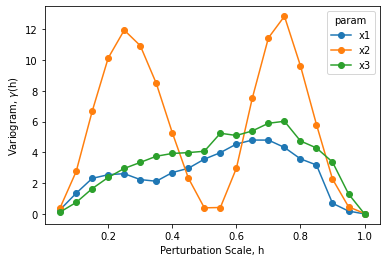

In [161]:
ymax = variogram_value.unstack(0).loc[0:0.6].max().max()
variogram_value.unstack(0).plot(xlabel='Perturbation Scale, h', ylabel='Variogram, $\gamma$(h)', marker='o')

In [136]:
# normalize data using mean normalization
df1 = morris_values[0].unstack(0).iloc[0]
df2 = sobol_value
df3 = ivars_df.loc[0.5]

normalized_maee = df1/df1.sum()
normalized_sobol = df2/df2.sum()
normalized_ivars50 = df3/df3.sum()
display(normalized_sobol)
display(normalized_ivars50)

param
x1    0.25417
x2    0.65552
x3    0.09031
dtype: float64

x1    0.072940
x2    0.857166
x3    0.069894
Name: 0.5, dtype: float64

In [137]:
# if bootstrapping is a thing compute bar chart confidence intervals
# not sure if this will be included in code
ivars50_err_upp = ivars_upp.loc[0.5]/df3.sum()
ivars50_err_low = ivars_low.loc[0.5]/df3.sum()
sobol_err_upp = (sobol_upp/df2.to_numpy().sum()).to_numpy().flatten()
sobol_err_low = (sobol_low/df2.to_numpy().sum()).to_numpy().flatten()

# subtract from normalized values so that error bars work properly
ivars50_err_upp = np.abs(ivars50_err_upp - normalized_ivars50)
ivars50_err_low = np.abs(ivars50_err_low - normalized_ivars50)
sobol_err_upp = np.abs(sobol_err_upp - normalized_sobol)
sobol_err_low = np.abs(sobol_err_low - normalized_sobol)

ivars50_err = np.array([ivars50_err_low, ivars50_err_upp])
sobol_err = np.array([sobol_err_low, sobol_err_upp])

display(ivars50_err)
display(sobol_err)

array([[0.04451071, 0.02031688, 0.06234332],
       [0.17357852, 0.22096512, 0.03466413]])

array([[0.11995154, 0.09906452, 0.07718628],
       [0.07838546, 0.58949454, 0.04733602]])

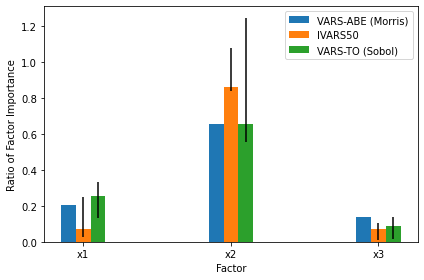

In [138]:
# create barchart
x = np.arange(len(parameters.keys()))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, normalized_maee, width, label='VARS-ABE (Morris)')
rects2 = ax.bar(x, normalized_ivars50, width, label='IVARS50', yerr=ivars50_err)
rects3 = ax.bar(x + width, normalized_sobol, width, label='VARS-TO (Sobol)', yerr=sobol_err)

# Add some text for labels, and custom x-axis tick labels, etc.
ax.set_ylabel('Ratio of Factor Importance')
ax.set_xlabel('Factor')
ax.set_xticks(x)
ax.set_xticklabels(parameters.keys())
ax.legend()

fig.tight_layout()

plt.show()

In [53]:
delta_h = 0.05
np.arange(start=delta_h/2, step=delta_h, stop=1)

array([0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425,
       0.475, 0.525, 0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875,
       0.925, 0.975])

In [52]:
upper_bound = 3.14
lower_bound = -3.14
num_bins = int(1/delta_h)
np.linspace(start=0, stop=(upper_bound-lower_bound), num=num_bins)

array([0.        , 0.33052632, 0.66105263, 0.99157895, 1.32210526,
       1.65263158, 1.98315789, 2.31368421, 2.64421053, 2.97473684,
       3.30526316, 3.63578947, 3.96631579, 4.29684211, 4.62736842,
       4.95789474, 5.28842105, 5.61894737, 5.94947368, 6.28      ])

In [142]:
bins = np.linspace(start=0, stop=3.14-(-3.14), num=int(1/delta_h)+1)
bins

array([0.   , 0.314, 0.628, 0.942, 1.256, 1.57 , 1.884, 2.198, 2.512,
       2.826, 3.14 , 3.454, 3.768, 4.082, 4.396, 4.71 , 5.024, 5.338,
       5.652, 5.966, 6.28 ])